In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import datetime

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
mclean_df = pd.read_csv("mclean_county_data_with_geocode.csv")
mclean_df = mclean_df.drop(['Unnamed: 0'], axis=1)

In [3]:
normal_df = pd.read_csv("normal_il_data_w_geocode.csv")
normal_df = normal_df.drop(['Unnamed: 0'], axis=1)

In [4]:
bloomington_df = pd.read_csv("bloomington_il_engineering_2014plus_w_geocode.csv")


In [5]:
#how many accidents were in bloomington, and normal

normal_count = normal_df.shape[0]
bloomington_count = bloomington_df.shape[0]
chicago_count = 2250

BLOOMINGTON_POP = 78902
NORMAL_POP= 54664
CHICAGO_POP = 2719000

blono_crash_per_capita = bloomington_count / float(BLOOMINGTON_POP)
normal_crash_per_capita = normal_count / float(NORMAL_POP)
chicago_crash_per_captia = chicago_count / float(CHICAGO_POP)


print " %0.2f crashes per 10,000 people in bloomington" % ( blono_crash_per_capita * 10000)
print  " %0.2f crashes per 10,000 people in normal" % (normal_crash_per_capita * 10000)
print  " %0.2f crashes per 10,000 people in chicago" % (chicago_crash_per_captia * 10000)



#Going to just use X2 here because lazy, sorry Bayesians.

obs = np.array(([normal_count, NORMAL_POP-normal_count], [bloomington_count, BLOOMINGTON_POP-bloomington_count]))
chi2, p, dof, expected = stats.chi2_contingency(obs)
print 'null hypothesis is that bloomington and normal are equally safe for bikers'
print "p = " +  str(p)
print "fail to reject the null at p < 0.5"

obs = np.array(([normal_count+bloomington_count, NORMAL_POP-normal_count+(BLOOMINGTON_POP-bloomington_count)],[chicago_count, CHICAGO_POP-chicago_count]))
chi2, p, dof, expected = stats.chi2_contingency(obs)
print 'null hypothesis is that bloomington and chicago are equally safe for bikers'
print "p = " +  str(p)
print "reject the null at p < 0.5"


 3.17 crashes per 10,000 people in bloomington
 2.56 crashes per 10,000 people in normal
 8.28 crashes per 10,000 people in chicago
null hypothesis is that bloomington and normal are equally safe for bikers
p = 0.634086256457
fail to reject the null at p < 0.5
null hypothesis is that bloomington and chicago are equally safe for bikers
p = 2.10456726769e-11
reject the null at p < 0.5


# Deeper Statistical Analysis

Problems - 
*  bike accidents are very rare (Future Mike:  Talk to AC.   You've found a zero inflated Poisson problem)
*  not much commonality between these datasets.
*  Bloomington's open data sucks


Approach
* take the common variables I do have
* engineer features
* descriptive stats on when accidents happen maybe?
* could try unsupervised ML
* ???

In [6]:
#combine common fields across datasets.
normal_clean = pd.DataFrame()
normal_clean['date'] = normal_df.date
normal_clean['time'] = normal_df.time
normal_clean['geo_loc'] = normal_df.geo_loc
normal_clean['lat_long'] = normal_df.lat_long
normal_clean['id'] = normal_df.id

bloomington_clean = pd.DataFrame()
bloomington_clean['date'] = bloomington_df.AC_DATE
bloomington_clean['time'] = bloomington_df.AC_TIME
bloomington_clean['geo_loc'] = bloomington_df.intersection
bloomington_clean['lat_long'] = bloomington_df.lat_long
bloomington_clean['id'] = bloomington_df.REPORT_NO


mclean_clean = pd.DataFrame()
mclean_clean['date'] = mclean_df.date
mclean_clean['time'] = mclean_df.time
mclean_clean['geo_loc'] = mclean_df.geo_loc
mclean_clean['lat_long'] = mclean_df.lat_long
mclean_clean['id'] = mclean_df.id

complete_df = bloomington_clean.append([normal_clean, mclean_clean], ignore_index=True)

In [7]:
#break out month, day, year

def get_month_day_year(date):
    month, day, year = date.split("/")

    return int(month), int(day), int(year)

complete_df['month'], complete_df['day'], complete_df['year'] = zip(*complete_df.date.map(get_month_day_year))

In [8]:
#time as an hour bin (could also do seconds of day or something for continuous, this is more human understandable)

def bin_hours(time):
    hour = int(time.split(':')[0])
    am_pm = time.split(' ')[1].lower()
    if am_pm == 'pm':
        hour +=12
    return hour

complete_df['hour_bin'] = complete_df.time.map(bin_hours)

In [9]:
#clean up lat and long

def clean_lat_long(x):
    x = x.strip('[]')
    latitude, longitude = x.split(',')
    return float(latitude), float(longitude)


complete_df['latitude'], complete_df['longitude'] = zip(*complete_df.lat_long.map(clean_lat_long))      

In [10]:
#day of week feature

def day_of_week(date):
    month, day, year = (int(x) for x in date.split('/'))
    if year < 99:
        year = 2000 + year   #do you want y3k, because this is how you get y3k
    dt = datetime.date(year, month, day)
    return dt.strftime("%A")

complete_df['day_of_week'] = complete_df.date.map(day_of_week)

In [11]:
complete_df.shape

(41, 12)

###TODO

*  MDS 
*  K-Means

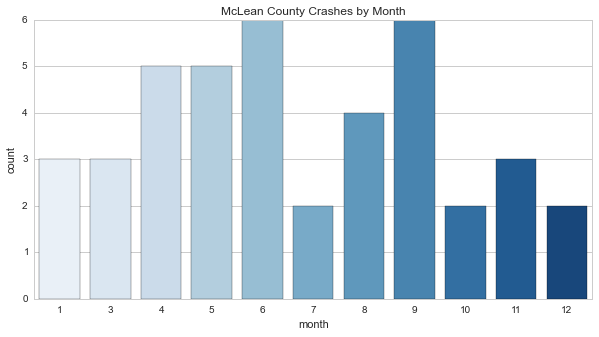

In [13]:
#visualize month
plt.figure(figsize=(10,5))
plt.title("McLean County Crashes by Month")
sns.countplot(x="month", data=complete_df, palette="Blues")
plt.legend()

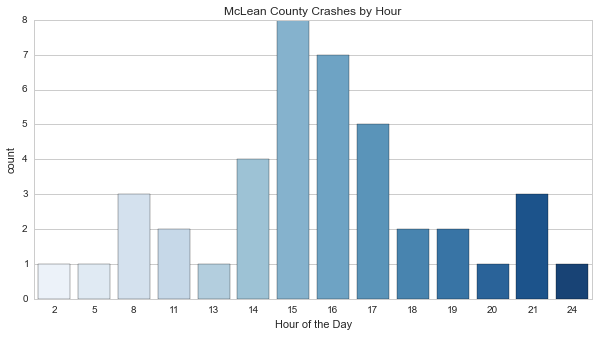

In [14]:
#visualize time
plt.figure(figsize=(10,5))
plt.title("McLean County Crashes by Hour")
sns.countplot(x="hour_bin", data=complete_df, palette="Blues", order = sorted(complete_df.hour_bin.unique()))
plt.xlabel("Hour of the Day")
plt.legend()

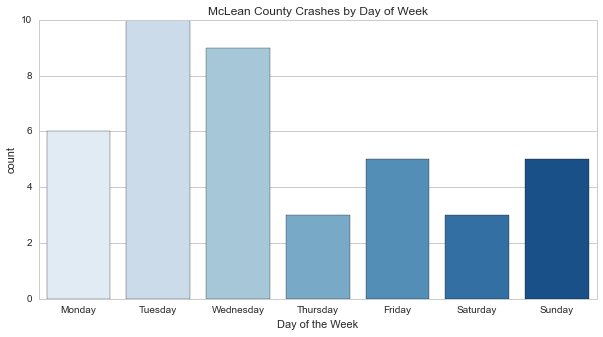

In [15]:
#visualize day
plt.figure(figsize=(10,5))
plt.title("McLean County Crashes by Day of Week")
sns.countplot(x="day_of_week", data=complete_df, palette="Blues", order =['Monday', 'Tuesday', 
                                                                             'Wednesday', 'Thursday','Friday',
                                                                             'Saturday','Sunday'] )
plt.xlabel("Day of the Week")
plt.legend()

In [37]:
normal_df.summary

0      cyclist on sidewalk, didn't stop at intersection
1                         kids playing in a parking lot
2                   cyclist ran a red light, hit by car
3      cyclist on sidewalk, didn't stop at intersection
4     motorist turned into the rear wheel of a cycli...
5     motorist looking left, hit cyclist crossing in...
6     motorist proceeded thru crosswalk without seei...
7     drunk cyclist, riding at night without lights,...
8     driver was looking south for traffic, pulled f...
9     driver was looking east for traffic and hit cy...
10    apparently both driver and cyclist failed to s...
11    cyclist was hit from behind, hit and run, mult...
12    juvenile cyclist riding down an alley hit a ca...
13    cyclist riding at night with no headlight, dar...
Name: summary, dtype: object